## W3-CRISPR-mcBEST workflow



The workflow allows for the simultaneous targeted engineering of up to 28 individual situated bases in the genome of Streptomyces, as shown by Whitford et. al 2023, thereby enabling efficient single-step multi-target engineering13. Similar to workflow 2, this workflow employs the CRISPR-BEST methodology but instead of performing base-editing on a single gene the method incorporates multiple guide RNAs as an array into the same vector (Figure 4A). This significantly enhances the efficiency of high-throughput genetic studies. The pCRISPR-cBEST plasmid file can be downloaded on the page along with the genome file for S.coelicor (A3) and streptoAIM will generate your plasmids, primers, checking primers and analyze the overhangs the target genes(Figure 4, S6). 


In [1]:
import sys
import os
from pydna.dseqrecord import Dseqrecord
from teemi.build.PCR import primer_tm_neb
import pandas as pd
from datetime import datetime


# Ensure the src directory is in the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from streptocad.sequence_loading.sequence_loading import (
    load_and_process_gene_sequences,
    load_and_process_plasmid)


from streptocad.utils import polymerase_dict, dataframe_to_seqrecords, generate_project_directory_structure
from streptocad.crispr.guideRNAcas3_9_12 import extract_sgRNAs, SgRNAargs
from streptocad.crispr.crispr_best import (
    identify_base_editing_sites,
    filter_sgrnas_for_base_editing,
    process_base_editing
)

from streptocad.cloning.golden_gate_cloning import (
    GoldenGateCloning,
    create_overhang_dataframe,
    digest_amplicons_w_BsaI
)

from streptocad.primers.primer_analysis import analyze_primers_and_hairpins
from streptocad.primers.primer_generation import create_idt_order_dataframe, primers_to_IDT
from streptocad.wet_lab.gel_simulation import simulate_gel_electrophoresis
from streptocad.cloning.plasmid_processing import annotate_plasmid_with_sgrnas
from streptocad.primers.primer_generation import create_dseqrecords_from_df,checking_primers


# Inputs


In [2]:
# 1 Add genome of choice (genbank, fasta)
path_to_genome = '../../data/genomes/Streptomyces_coelicolor_A3_chromosome.gb'
genome = load_and_process_plasmid(path_to_genome)

# 2 Add plasmid 
path_to_plasmid = '../../data/plasmids/pCRISPR-MCBE_Csy4_kasopGFP.gb'
clean_plasmid = load_and_process_plasmid(path_to_plasmid)

# 3 Choose genes to knock out (list)
genes_to_KO = ['SCO5087', 'SCO5089', 'SCO5090']

#### Advanced settings ####
# 4 Filtering metrics for sgRNAs
gc_upper = 0.72
gc_lower = 0.2
off_target_seed = 13
off_target_upper = 10
cas_type='cas9'
number_of_sgRNAs_per_group = 5

# 5 Choose polymerase and target melting temperature
chosen_polymerase = polymerase_dict['Phusion High-Fidelity DNA Polymerase (GC Buffer)']
melting_temperature = 65
primer_concentration = 0.4 
primer_number_increment = 23
flanking_region=500


# 6 Choose overlapping sequences for our plasmid we can use the following
restriction_overhang_f = "GATCGggtctcc"
restriction_overhang_r = "GATCAGGTCTCg"
backbone_overhang_f = "cATG"
backbone_overhang_r = "cTAG"
cys4 = "gTTCACTGCCGTATAGGCAGCTAAGAAA"
sgRNA_handle_cys4_site = [Dseqrecord('GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTT', name = 'sgRNA_handle_cys4')]

# Computation

In [3]:

# Initialize SgRNAargs with desired parameters
args = SgRNAargs(path_to_genome, 
                genes_to_KO,
                step=['find', 'filter'],
                gc_upper = gc_upper,
                gc_lower = gc_lower,
                off_target_seed = off_target_seed,
                off_target_upper = off_target_upper,
                cas_type='cas9'
                )

sgrna_df = extract_sgRNAs(args)
sgrna_df

sgRNA generated were outside the designated border in SCO5087. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5087. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5087. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5089. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5089. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5090. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5090. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5090. To incorporate this extent borders. Skipping to 

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count
336,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,32,0.65,CGG,TGGACCACCCGGTGTTCTCC,CCCGGTGTTCTCC,0
332,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,61,0.70,CGG,CGTGGAGTGCGCCGGTGAGA,TGCGCCGGTGAGA,0
331,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,65,0.70,CGG,GAGTGCGCCGGTGAGACGGA,CCGGTGAGACGGA,0
330,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,66,0.70,GGG,AGTGCGCCGGTGAGACGGAC,CGGTGAGACGGAC,0
328,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,80,0.70,CGG,ACGGACGGGACGGACCTGTC,GGACGGACCTGTC,0
...,...,...,...,...,...,...,...,...,...,...,...
406,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,691,0.70,TGG,GCCGGATCGAACGGGTGGTG,CGAACGGGTGGTG,2
78,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,-1,745,0.65,GGG,CGACGACGATCGGGGTGATC,GATCGGGGTGATC,2
452,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,1,890,0.65,CGG,ACCCATCTGCGCGAGGTGCT,TGCGCGAGGTGCT,3
192,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,1,838,0.70,TGG,TACGCGGGACGGCTTCGTGC,GACGGCTTCGTGC,3


In [4]:

# Example usage
path_to_genome = '../../data/genomes/Streptomyces_coelicolor_A3_chromosome.gb'

# Load gene sequences
gene_sequences = load_and_process_gene_sequences(path_to_genome)
genes_to_KO_dict = {locus_tag: gene_sequences[locus_tag] for locus_tag in genes_to_KO if locus_tag in gene_sequences}

# Identify and annotate base editing sites
sgrna_df_with_editing = identify_base_editing_sites(sgrna_df)

filtered_sgrna_df_for_base_editing = filter_sgrnas_for_base_editing(sgrna_df_with_editing)
filtered_sgrna_df_for_base_editing

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count,editable_cytosines
336,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,32,0.65,CGG,TGGACCACCCGGTGTTCTCC,CCCGGTGTTCTCC,0,"5,6,8,9,10"
332,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,61,0.70,CGG,CGTGGAGTGCGCCGGTGAGA,TGCGCCGGTGAGA,0,10
331,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,65,0.70,CGG,GAGTGCGCCGGTGAGACGGA,CCGGTGAGACGGA,0,"6,8,9"
330,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,66,0.70,GGG,AGTGCGCCGGTGAGACGGAC,CGGTGAGACGGAC,0,"5,7,8"
328,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,80,0.70,CGG,ACGGACGGGACGGACCTGTC,GGACGGACCTGTC,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
406,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,691,0.70,TGG,GCCGGATCGAACGGGTGGTG,CGAACGGGTGGTG,2,"3,8"
78,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,-1,745,0.65,GGG,CGACGACGATCGGGGTGATC,GATCGGGGTGATC,2,"4,7"
452,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,1,890,0.65,CGG,ACCCATCTGCGCGAGGTGCT,TGCGCGAGGTGCT,3,"3,4,7,10"
192,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,1,838,0.70,TGG,TACGCGGGACGGCTTCGTGC,GACGGCTTCGTGC,3,"3,5,10"


In [5]:

# Process the DataFrame to apply C-to-T mutations
mutated_sgrna_df = process_base_editing(filtered_sgrna_df_for_base_editing, genes_to_KO_dict, only_stop_codons = False)
mutated_sgrna_df

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count,editable_cytosines,mutations
336,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,32,0.65,CGG,TGGACCACCCGGTGTTCTCC,CCCGGTGTTCTCC,0,"5,6,8,9,10","R8Q, V9I, V10I"
331,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,65,0.70,CGG,GAGTGCGCCGGTGAGACGGA,CCGGTGAGACGGA,0,"6,8,9",A18V
330,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,66,0.70,GGG,AGTGCGCCGGTGAGACGGAC,CGGTGAGACGGAC,0,"5,7,8",A18V
327,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,106,0.65,AGG,CTTCCTCGACCTCCGCTTCG,GACCTCCGCTTCG,0,"4,5,7,10",L31F
326,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,113,0.60,CGG,GACCTCCGCTTCGAGGACAT,GCTTCGAGGACAT,0,"3,4,6,7,9","L33F, R34C"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,691,0.70,TGG,GCCGGATCGAACGGGTGGTG,CGAACGGGTGGTG,2,"3,8",R230Q
78,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,-1,745,0.65,GGG,CGACGACGATCGGGGTGATC,GATCGGGGTGATC,2,"4,7","V247I, V248I"
452,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,1,890,0.65,CGG,ACCCATCTGCGCGAGGTGCT,TGCGCGAGGTGCT,3,"3,4,7,10","H292Y, R294C"
192,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,1,838,0.70,TGG,TACGCGGGACGGCTTCGTGC,GACGGCTTCGTGC,3,"3,5,10","T274M, R275W"


In [6]:
# Process the DataFrame to apply C-to-T mutations
mutated_sgrna_df = process_base_editing(filtered_sgrna_df_for_base_editing, 
                                        genes_to_KO_dict, 
                                        only_stop_codons = True)
mutated_sgrna_df

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count,editable_cytosines,mutations
537,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,1,140,0.65,CGG,CACGTACAGGTCCTGGAGCG,AGGTCCTGGAGCG,2,"3,7",Q43*
321,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,167,0.70,CGG,GCGCGACTCGAGAGCCGGTA,TCGAGAGCCGGTA,0,"4,7,9","R51*, L52F"
354,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,174,0.65,CGG,CGCCCAGATCCGGAAGCGTT,ATCCGGAAGCGTT,0,"3,4,5,10","W57*, A58T"
356,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,208,0.65,CGG,GGGACGTCCAGGTCTTCACC,CCAGGTCTTCACC,0,"5,8,9",W67*
17,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,-1,210,0.60,GGG,GAGCAGTTCCCAGAACTGCC,TCCCAGAACTGCC,0,"4,9,10","W67*, E68K"
54,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,-1,522,0.70,CGG,GTCGACCTCCCAGTCACGGC,TCCCAGTCACGGC,0,"3,6,7,9,10","W171*, E172K, V173I, D174N"
474,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,1,640,0.60,TGG,GACCGTCCAGGACATGACCA,CAGGACATGACCA,0,"3,4,7,8","T208I, Q210*"


In [7]:
# Filter the DataFrame to retain only up to 5 sgRNA sequences per locus_tag
filtered_df = mutated_sgrna_df.groupby('locus_tag').head(number_of_sgRNAs_per_group)
filtered_df

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count,editable_cytosines,mutations
537,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,1,140,0.65,CGG,CACGTACAGGTCCTGGAGCG,AGGTCCTGGAGCG,2,"3,7",Q43*
321,Streptomyces_coelicolor_A3_chromosome,SCO5089,5532449,1,1,167,0.70,CGG,GCGCGACTCGAGAGCCGGTA,TCGAGAGCCGGTA,0,"4,7,9","R51*, L52F"
354,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,174,0.65,CGG,CGCCCAGATCCGGAAGCGTT,ATCCGGAAGCGTT,0,"3,4,5,10","W57*, A58T"
356,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,-1,208,0.65,CGG,GGGACGTCCAGGTCTTCACC,CCAGGTCTTCACC,0,"5,8,9",W67*
17,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,-1,210,0.60,GGG,GAGCAGTTCCCAGAACTGCC,TCCCAGAACTGCC,0,"4,9,10","W67*, E68K"
54,Streptomyces_coelicolor_A3_chromosome,SCO5087,5529801,1,-1,522,0.70,CGG,GTCGACCTCCCAGTCACGGC,TCCCAGTCACGGC,0,"3,6,7,9,10","W171*, E172K, V173I, D174N"
474,Streptomyces_coelicolor_A3_chromosome,SCO5090,5532706,1,1,640,0.60,TGG,GACCGTCCAGGACATGACCA,CAGGACATGACCA,0,"3,4,7,8","T208I, Q210*"


## Output

In [8]:
sgRNA_list = dataframe_to_seqrecords(filtered_df)
sgRNA_list

[Dseqrecord(-20),
 Dseqrecord(-20),
 Dseqrecord(-20),
 Dseqrecord(-20),
 Dseqrecord(-20),
 Dseqrecord(-20),
 Dseqrecord(-20)]

In [9]:

sgRNA_handle_cys4_sites = sgRNA_handle_cys4_site*len(sgRNA_list)

golden_gate = GoldenGateCloning(sgRNA_list,
                                sgRNA_handle_cys4_sites, 
                                target_tm= melting_temperature,
                                restriction_overhang_f = "GATCGggtctcc",
                                restriction_overhang_r = "GATCAGGTCTCg",
                                backbone_overhang_f = "cATG",
                                backbone_overhang_r = "cTAG",
                                cys4 = "gTTCACTGCCGTATAGGCAGCTAAGAAA",
                                tm_function = primer_tm_neb, 
                                primer_incrementation = primer_number_increment, 
                                polymerase = chosen_polymerase ) 

In [10]:
primer_df = golden_gate.generate_primer_dataframe()
primer_df

,template,f_primer_anneal(5-3),r_primer_anneal(5-3),f_tm,r_tm,ta,f_primer_sequences(5-3),r_primer_sequences(5-3),f_primer_name,r_primer_name
0,sgRNA_handle_cys4,GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGC,AAAAAAGCACCGACTCGGT,63,59,63,GATCGGGTCTCCCATGGTTCACTGCCGTATAGGCAGCTAAGAAACA...,GATCAGGTCTCGGCGCAAAAAAGCACCGACTCGGT,primer_23,primer_24
1,sgRNA_handle_cys4,GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGC,AAAAAAGCACCGACTCGGT,63,59,63,GATCGGGTCTCCGCGCGACTCGAGAGCCGGTAGTTTTAGAGCTAGA...,GATCAGGTCTCGGGCGAAAAAAGCACCGACTCGGT,primer_25,primer_26
2,sgRNA_handle_cys4,GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGC,AAAAAAGCACCGACTCGGT,63,59,63,GATCGGGTCTCCCGCCCAGATCCGGAAGCGTTGTTTTAGAGCTAGA...,GATCAGGTCTCGTCCCAAAAAAGCACCGACTCGGT,primer_27,primer_28
3,sgRNA_handle_cys4,GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGC,AAAAAAGCACCGACTCGGT,63,59,63,GATCGGGTCTCCGGGACGTCCAGGTCTTCACCGTTTTAGAGCTAGA...,GATCAGGTCTCGGCTCAAAAAAGCACCGACTCGGT,primer_29,primer_30
4,sgRNA_handle_cys4,GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGC,AAAAAAGCACCGACTCGGT,63,59,63,GATCGGGTCTCCGAGCAGTTCCCAGAACTGCCGTTTTAGAGCTAGA...,GATCAGGTCTCGCGACAAAAAAGCACCGACTCGGT,primer_31,primer_32
5,sgRNA_handle_cys4,GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGC,AAAAAAGCACCGACTCGGT,63,59,63,GATCGGGTCTCCGTCGACCTCCCAGTCACGGCGTTTTAGAGCTAGA...,GATCAGGTCTCGGGTCAAAAAAGCACCGACTCGGT,primer_33,primer_34
6,sgRNA_handle_cys4,GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGC,AAAAAAGCACCGACTCGGT,63,59,63,GATCGGGTCTCCGACCGTCCAGGACATGACCAGTTTTAGAGCTAGA...,GATCAGGTCTCGCTAGAAAAAAGCACCGACTCGGT,primer_35,primer_36


In [11]:
# Primer analysis
analysis_of_primers = analyze_primers_and_hairpins(primer_df)
analysis_of_primers

Skipping analysis for primer pair primer_23 & primer_24 due to length constraints.
Skipping analysis for primer pair primer_25 & primer_26 due to length constraints.
Skipping analysis for primer pair primer_27 & primer_28 due to length constraints.
Skipping analysis for primer pair primer_29 & primer_30 due to length constraints.
Skipping analysis for primer pair primer_31 & primer_32 due to length constraints.
Skipping analysis for primer pair primer_33 & primer_34 due to length constraints.
Skipping analysis for primer pair primer_35 & primer_36 due to length constraints.


""


In [12]:
# 2 Ready made IDT format
idt_df = create_idt_order_dataframe(primer_df, concentration="25nm", purification="STD")
idt_df

,Name,Sequence,Concentration,Purification
0,primer_23,GATCGGGTCTCCCATGGTTCACTGCCGTATAGGCAGCTAAGAAACA...,25nm,STD
1,primer_25,GATCGGGTCTCCGCGCGACTCGAGAGCCGGTAGTTTTAGAGCTAGA...,25nm,STD
2,primer_27,GATCGGGTCTCCCGCCCAGATCCGGAAGCGTTGTTTTAGAGCTAGA...,25nm,STD
3,primer_29,GATCGGGTCTCCGGGACGTCCAGGTCTTCACCGTTTTAGAGCTAGA...,25nm,STD
4,primer_31,GATCGGGTCTCCGAGCAGTTCCCAGAACTGCCGTTTTAGAGCTAGA...,25nm,STD
5,primer_33,GATCGGGTCTCCGTCGACCTCCCAGTCACGGCGTTTTAGAGCTAGA...,25nm,STD
6,primer_35,GATCGGGTCTCCGACCGTCCAGGACATGACCAGTTTTAGAGCTAGA...,25nm,STD
7,primer_24,GATCAGGTCTCGGCGCAAAAAAGCACCGACTCGGT,25nm,STD
8,primer_26,GATCAGGTCTCGGGCGAAAAAAGCACCGACTCGGT,25nm,STD
9,primer_28,GATCAGGTCTCGTCCCAAAAAAGCACCGACTCGGT,25nm,STD


In [13]:
list_of_amplicons = golden_gate.simulate_pcrs()

SCO5090_140_pcr_products
SCO5089_167_pcr_products
SCO5090_174_pcr_products
SCO5090_208_pcr_products
SCO5087_210_pcr_products
SCO5087_522_pcr_products
SCO5090_640_pcr_products


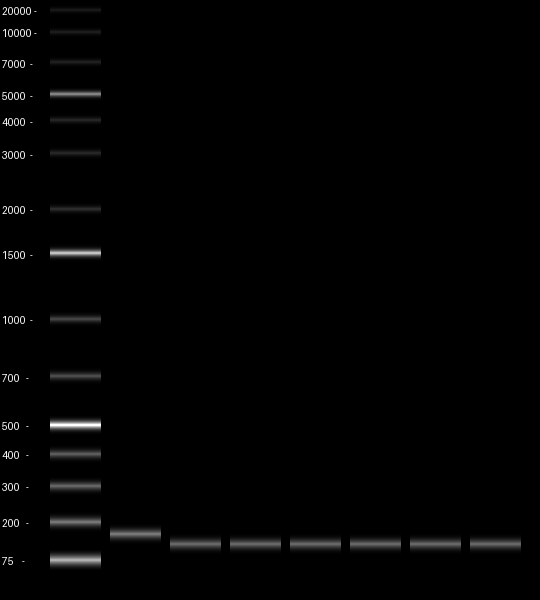

In [14]:
simulate_gel_electrophoresis(list_of_amplicons)

In [15]:
overhangs = create_overhang_dataframe(list_of_amplicons)
overhangs

,Amplicon Name,5' Overhang,5' Duplicate,3' Overhang,3' Duplicate
0,Amplicon_SCO5090_140_pcr_products,CATG,No,GCGC,No
1,Amplicon_SCO5089_167_pcr_products,GCGC,No,CGCC,No
2,Amplicon_SCO5090_174_pcr_products,CGCC,No,GGGA,No
3,Amplicon_SCO5090_208_pcr_products,GGGA,No,GAGC,No
4,Amplicon_SCO5087_210_pcr_products,GAGC,No,GTCG,No
5,Amplicon_SCO5087_522_pcr_products,GTCG,No,GACC,No
6,Amplicon_SCO5090_640_pcr_products,GACC,No,CTAG,No


In [16]:
digest_amplicons = digest_amplicons_w_BsaI(list_of_amplicons)
for digest in digest_amplicons: 
    print(digest.figure())

Dseqrecord(-138)
CATGGTTCACTGCCGTATAGGCAGCTAAGAAACACGTACAGGTCCTGGAGCGGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTT    
    CAAGTGACGGCATATCCGTCGATTCTTTGTGCATGTCCAGGACCTCGCCAAAATCTCGATCTTTATCGTTCAATTTTATTCCGATCAGGCAATAGTTGAACTTTTTCACCGTGGCTCAGCCACGAAAAAACGCG
Dseqrecord(-106)
GCGCGACTCGAGAGCCGGTAGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTT    
    CTGAGCTCTCGGCCATCAAAATCTCGATCTTTATCGTTCAATTTTATTCCGATCAGGCAATAGTTGAACTTTTTCACCGTGGCTCAGCCACGAAAAAAGCGG
Dseqrecord(-106)
CGCCCAGATCCGGAAGCGTTGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTT    
    GTCTAGGCCTTCGCAACAAAATCTCGATCTTTATCGTTCAATTTTATTCCGATCAGGCAATAGTTGAACTTTTTCACCGTGGCTCAGCCACGAAAAAACCCT
Dseqrecord(-106)
GGGACGTCCAGGTCTTCACCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTT    
    GCAGGTCCAGAAGTGGCAAAATCTCGATCTTTATCGTTCAATTTTATTCCGATCAGGCAATAGTTGAACTTTTTCACCGTGGCTCAGCCACGAAAAAACTCG
Dseqrecord(-

In [17]:
digest_amplicons

[Dseqrecord(-138),
 Dseqrecord(-106),
 Dseqrecord(-106),
 Dseqrecord(-106),
 Dseqrecord(-106),
 Dseqrecord(-106),
 Dseqrecord(-106)]

In [18]:
from Bio.Restriction import NcoI, NheI

try:
    linear_plasmid, smaller_frag = sorted(clean_plasmid.cut(NcoI, NheI), key=lambda x: len(x), reverse=True)
    for i in range(len(digest_amplicons)):
        # Assuming digest_amplicons[i] is a Dseqrecord, concatenate Dseq sequences
        linear_plasmid.seq += digest_amplicons[i].seq
    
    try:
        rec_vec = linear_plasmid.looped()
        print("Successfully looped the plasmid.")
    except Exception as e:
        print(f"An error occurred while trying to loop the plasmid: {e}")
        # Handle the error or provide an alternative action here
        rec_vec = None  # Example response; adjust as needed

except Exception as e:
    print(f"An error occurred during plasmid digestion or preparation: {e}")
    # Additional error handling or cleanup here
    rec_vec = None  # Ensure rec_vec is defined even if an error occurs


# Constructing a meaningful name, ID, and description for the assembled plasmid using user input
plasmid_components = "_".join(genes_to_KO)  # Concatenates gene names from the user's list
plasmid_purpose = "pCRISPR-mcBEST_w_sgRNAs"  # Example: purpose of the plasmid

rec_vec.name = f'{plasmid_purpose}'#_{plasmid_components}'
rec_vec.id = rec_vec.name  # Using the same value for ID as for name for simplicity
rec_vec.description = f'CRISPR-mcBEST_plasmid {", ".join(genes_to_KO)} for gene KNOCK-DOWN, assembled using StreptoAIM.'
rec_vec.id

Successfully looped the plasmid.


'pCRISPR-mcBEST_w_sgRNAs'

In [19]:
# annotate the plasmid correctly
annotate_plasmid_with_sgrnas(rec_vec, filtered_df)

Dseqrecord(o13210)

In [20]:
print_plasmid = False

if print_plasmid: 
    rec_vec.write(f"../../data/plasmids/sgRNA_plasmids_pCRISPR_mcBEST/{rec_vec.id}.gb")


In [21]:
# Getting checking primers
checking_primers_df = checking_primers(path_to_genome, genes_to_KO, 
                                       flanking_region=flanking_region,
                                       target_tm = melting_temperature, 
                                        primer_concentration = primer_concentration, 
                                        polymerase = chosen_polymerase)
checking_primers_df

,Locus Tag,f_primer_name,r_primer_name,f_primer_sequences(5-3),r_primer_sequences(5-3),f_tm,r_tm,ta
0,SCO5087,SCO5087_fwd_checking_primer,SCO5087_rev_checking_primer,GACGATTCGGCCCGTG,CAGGGCGTCCAGGC,59,58,61
1,SCO5089,SCO5089_fwd_checking_primer,SCO5089_rev_checking_primer,CGTACGGCGAACTCGC,GTCCCCGGACGGC,59,57,60
2,SCO5090,SCO5090_fwd_checking_primer,SCO5090_rev_checking_primer,GGCGGCGGCCC,GACGTCCCCCGCGAAC,57,62,61


In [22]:
# making the primers into dseqrecords
checking_primers_df_idt = create_idt_order_dataframe(checking_primers_df)
checking_primers_df_idt


,Name,Sequence,Concentration,Purification
0,SCO5087_fwd_checking_primer,GACGATTCGGCCCGTG,25nm,STD
1,SCO5089_fwd_checking_primer,CGTACGGCGAACTCGC,25nm,STD
2,SCO5090_fwd_checking_primer,GGCGGCGGCCC,25nm,STD
3,SCO5087_rev_checking_primer,CAGGGCGTCCAGGC,25nm,STD
4,SCO5089_rev_checking_primer,GTCCCCGGACGGC,25nm,STD
5,SCO5090_rev_checking_primer,GACGTCCCCCGCGAAC,25nm,STD


In [23]:

full_idt = pd.concat([idt_df, checking_primers_df_idt])
full_idt

,Name,Sequence,Concentration,Purification
0,primer_23,GATCGGGTCTCCCATGGTTCACTGCCGTATAGGCAGCTAAGAAACA...,25nm,STD
1,primer_25,GATCGGGTCTCCGCGCGACTCGAGAGCCGGTAGTTTTAGAGCTAGA...,25nm,STD
2,primer_27,GATCGGGTCTCCCGCCCAGATCCGGAAGCGTTGTTTTAGAGCTAGA...,25nm,STD
3,primer_29,GATCGGGTCTCCGGGACGTCCAGGTCTTCACCGTTTTAGAGCTAGA...,25nm,STD
4,primer_31,GATCGGGTCTCCGAGCAGTTCCCAGAACTGCCGTTTTAGAGCTAGA...,25nm,STD
5,primer_33,GATCGGGTCTCCGTCGACCTCCCAGTCACGGCGTTTTAGAGCTAGA...,25nm,STD
6,primer_35,GATCGGGTCTCCGACCGTCCAGGACATGACCAGTTTTAGAGCTAGA...,25nm,STD
7,primer_24,GATCAGGTCTCGGCGCAAAAAAGCACCGACTCGGT,25nm,STD
8,primer_26,GATCAGGTCTCGGGCGAAAAAAGCACCGACTCGGT,25nm,STD
9,primer_28,GATCAGGTCTCGTCCCAAAAAAGCACCGACTCGGT,25nm,STD


In [24]:
import os
import json
import pandas as pd
from datetime import datetime
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from pydna.dseqrecord import Dseqrecord


def generate_project_directory_structure(
    project_name,
    input_files,
    output_files,
    input_values,
    markdown_file_paths=None

):
    # Define the main project directory
    project_dir = f"./{project_name}"
    
    # Define input and output directories
    inputs_dir = os.path.join(project_dir, "inputs")
    outputs_dir = os.path.join(project_dir, "outputs")
    
    # Create directories if they don't exist
    os.makedirs(inputs_dir, exist_ok=True)
    os.makedirs(outputs_dir, exist_ok=True)
    
    # Process and save input files
    for input_file in input_files:
        file_save_path = os.path.join(inputs_dir, input_file['name'])
        
        if isinstance(input_file['content'], list) and all(isinstance(seq, Dseqrecord) for seq in input_file['content']):
            # Save each Dseqrecord in the list as a separate GenBank file
            for i, seq in enumerate(input_file['content']):
                seq_file_save_path = os.path.join(inputs_dir, f"{input_file['name'].split('.')[0]}_{i}.gb")
                SeqIO.write(seq, seq_file_save_path, "genbank")
        elif isinstance(input_file['content'], SeqRecord):
            SeqIO.write(input_file['content'], file_save_path, "genbank")
        else:
            with open(file_save_path, 'w') as file:
                file.write(input_file['content'])
    
    
    # Save the input values as a JSON file
    input_values_path = os.path.join(inputs_dir, "input_values.json")
    
    with open(input_values_path, 'w') as json_file:
        json.dump(input_values, json_file, indent=4)
    
    # Process and save output files
    for output_file in output_files:
        file_save_path = os.path.join(outputs_dir, output_file['name'])
        
        if output_file['name'].endswith(".csv"):
            if isinstance(output_file['content'], pd.DataFrame):
                output_file['content'].to_csv(file_save_path, index=False)
            else:
                raise TypeError(f"Expected a DataFrame for {output_file['name']}, but got {type(output_file['content'])}")
        elif output_file['name'].endswith(".gb"):
            if isinstance(output_file['content'], list) and all(isinstance(record, SeqRecord) for record in output_file['content']):
                # Save each SeqRecord in the list separately
                for i, record in enumerate(output_file['content']):
                    record_file_save_path = os.path.join(outputs_dir, f"{record.id}_{i}.gb")
                    SeqIO.write(record, record_file_save_path, "genbank")
            elif isinstance(output_file['content'], SeqRecord):
                SeqIO.write(output_file['content'], file_save_path, "genbank")
        else:
            with open(file_save_path, 'w') as file:
                file.write(output_file['content'])


                    # Process and save markdown files from paths
    if markdown_file_paths:
        for md_file_path in markdown_file_paths:
            md_file_name = os.path.basename(md_file_path)
            md_file_save_path = os.path.join(outputs_dir, md_file_name)
            with open(md_file_path, 'r') as file:
                md_content = file.read()
            with open(md_file_save_path, 'w') as file:
                file.write(md_content)
    
    
    print(f"Project structure for '{project_name}' created successfully.")


## Folder with all the generated I/O

In [25]:

# Example: 

input_files = [
    {"name": "input_genome.gb", "content": genome},
    {"name": "input_plasmid.gb", "content": clean_plasmid}
]



output_files = [
    {"name": "mcBEST_w_sgRNAs.gb", "content": rec_vec},
    {"name": "overhang_df.csv", "content": overhangs},
    {"name": "pcr_df.csv", "content": primer_df},
    {"name": "full_idt.csv", "content": full_idt},
    {"name": "mutated_sgrna_df.csv", "content": mutated_sgrna_df},
    {"name": "filtered_df.csv", "content": filtered_df}
]

input_values = {
    "genes_to_knockout": ['SCO5087', 'SCO5089', 'SCO5090'],
    "filtering_metrics": {
        "gc_upper": gc_upper,
        "gc_lower": gc_lower,
        "off_target_seed": off_target_seed,
        "off_target_upper": off_target_upper,
        "cas_type": cas_type,
        "number_of_sgRNAs_per_group": number_of_sgRNAs_per_group
    },
    "polymerase_settings": {
        "chosen_polymerase": chosen_polymerase,
        "melting_temperature": melting_temperature,
        "primer_concentration": primer_concentration,
        "primer_number_increment": primer_number_increment,
        "flanking_region": flanking_region
    }, # TODO might want to incorporate this to the app
    "overlapping_sequences": {
        "restriction_overhang_f": restriction_overhang_f,
        "restriction_overhang_r": restriction_overhang_r,
        "backbone_overhang_f": backbone_overhang_f,
        "backbone_overhang_r": backbone_overhang_r,
        "cys4": cys4,
        "sgRNA_handle_cys4_site": str(sgRNA_handle_cys4_site[0].seq)
    }
}


# Paths to Markdown files
markdown_file_paths = [
    "../../protocols/conjugation_protcol.md",
    "../../protocols/multi_target_crispr_plasmid_protcol.md"

]

# Data and time
timestamp = datetime.utcnow().isoformat()

generate_project_directory_structure(
    project_name=f"CRISPR_mcBEST_workflow_{timestamp}",
    input_files=input_files,
    output_files=output_files,
    input_values=input_values,
    markdown_file_paths=markdown_file_paths
)


Project structure for 'CRISPR_mcBEST_workflow_2024-06-28T09:13:37.723360' created successfully.


/Users/lucaslevassor/opt/anaconda3/envs/streptocad/lib/python3.11/site-packages/Bio/SeqIO/InsdcIO.py:728: BiopythonWarning: Increasing length of locus line to allow long name. This will result in fields that are not in usual positions.
  warnings.warn(
